In [5]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 124.9/124.9 MB 2.8 MB/s eta 0:00:00


In [6]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [7]:
#loading the dataset
data = pd.read_csv('hp1.csv')

In [27]:
# Display Data Information
print("Data Information:")
print(data.info())

Data Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13274 entries, 0 to 13319
Columns: 1306 entries, size to location_whitefiled
dtypes: float64(5), uint8(1301)
memory usage: 17.1 MB
None


In [29]:
# Display First 5 Rows
print("\nFirst 5 Rows of the Data:")
print(data.head())


First 5 Rows of the Data:
   size  total_sqft  bath  balcony   price  area_type_Carpet  Area  \
0   2.0      1056.0   2.0      1.0   39.07                       0   
1   4.0      2600.0   5.0      3.0  120.00                       0   
2   3.0      1440.0   2.0      3.0   62.00                       0   
3   3.0      1521.0   3.0      1.0   95.00                       0   
4   2.0      1200.0   2.0      1.0   51.00                       0   

   area_type_Plot  Area  area_type_Super built-up  Area  location_ Banaswadi  \
0                     0                               1                    0   
1                     1                               0                    0   
2                     0                               0                    0   
3                     0                               1                    0   
4                     0                               1                    0   

   location_ Basavangudi  ...  location_rr nagar  location_sankeswari  

**Data Preprocessing**

In [9]:
#data cleaning
#Drop rows where 'price' or 'total_sqft' is missing

data = data.dropna(subset=['price', 'total_sqft'])

In [11]:
# Extract numerical values from 'size' (e.g., "2 BHK" -> 2)

data['size'] = data['size'].str.extract('(\d+)').astype(float)


In [12]:
# Convert 'total_sqft' to a single numerical value (handling ranges like "1200 - 1500")

def convert_sqft(sqft):
    try:
        if '-' in sqft:
            range_values = list(map(float, sqft.split('-')))
            return (range_values[0] + range_values[1]) / 2
        return float(sqft)
    except:
        return None

In [13]:
data['total_sqft'] = data['total_sqft'].apply(convert_sqft)
data = data.dropna(subset=['total_sqft'])


In [14]:
# Fill missing values in 'bath' and 'balcony' with median values

data['bath'] = data['bath'].fillna(data['bath'].median())
data['balcony'] = data['balcony'].fillna(data['balcony'].median())


In [15]:
# Drop irrelevant columns

data = data.drop(['society', 'availability'], axis=1)

In [17]:
# One-hot encode 'area_type' and 'location'

data = pd.get_dummies(data, columns=['area_type', 'location'], drop_first=True)

In [18]:
# Define Features and Target

X = data.drop('price', axis=1)
y = data['price']


In [19]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Standardize Numerical Features

scaler = StandardScaler()
X_train[['total_sqft', 'size', 'bath', 'balcony']] = scaler.fit_transform(X_train[['total_sqft', 'size', 'bath', 'balcony']])
X_test[['total_sqft', 'size', 'bath', 'balcony']] = scaler.transform(X_test[['total_sqft', 'size', 'bath', 'balcony']])

In [21]:
# Hybrid Algorithm: XGBoost and Random Forest with Linear Regression as Meta-Regressor

base_models = [
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]

meta_model = LinearRegression()

hybrid_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

In [22]:
# Train Hybrid Model

hybrid_model.fit(X_train, y_train)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...one, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=LinearRegression())

In [23]:
# Predict on Test Data
y_pred_hybrid = hybrid_model.predict(X_test)

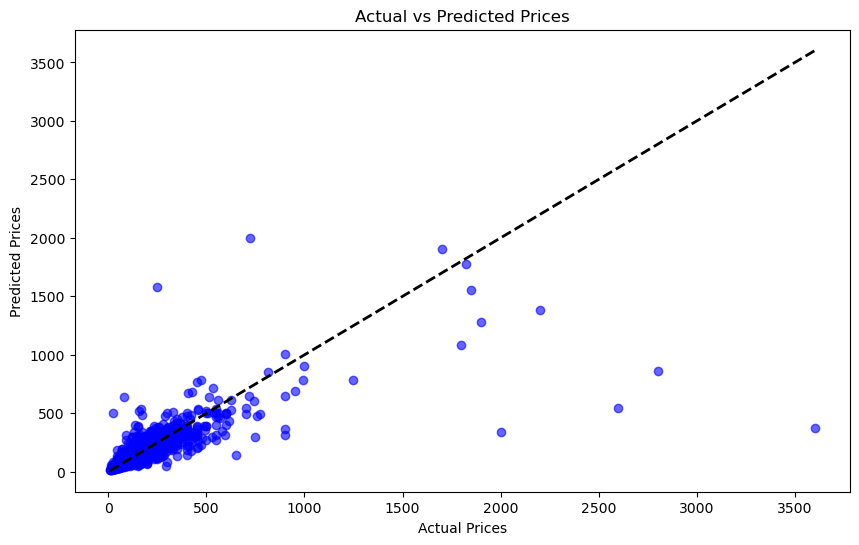

In [33]:
# Visualization: Actual vs Predicted Prices

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_hybrid, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()


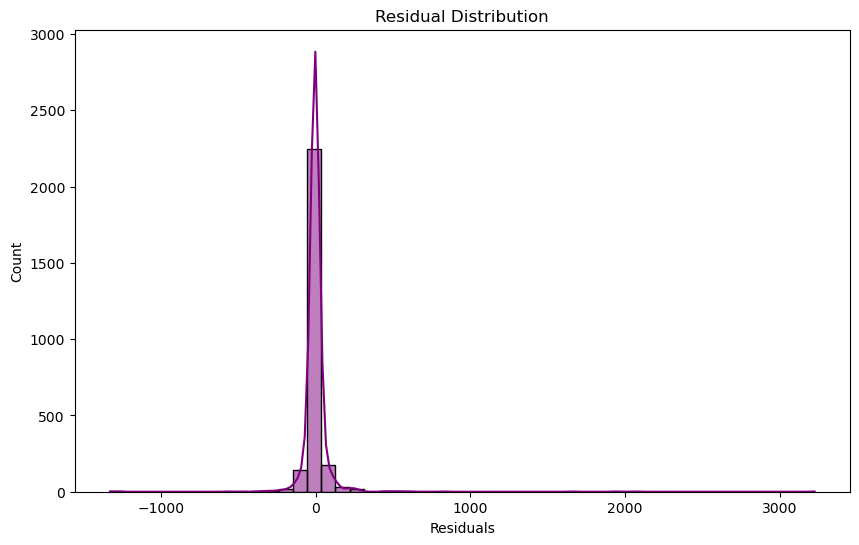

In [35]:
# Visualization: Residual Plot

import seaborn as sns
residuals = y_test - y_pred_hybrid
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.xlabel('Residuals')
plt.title('Residual Distribution')
plt.show()


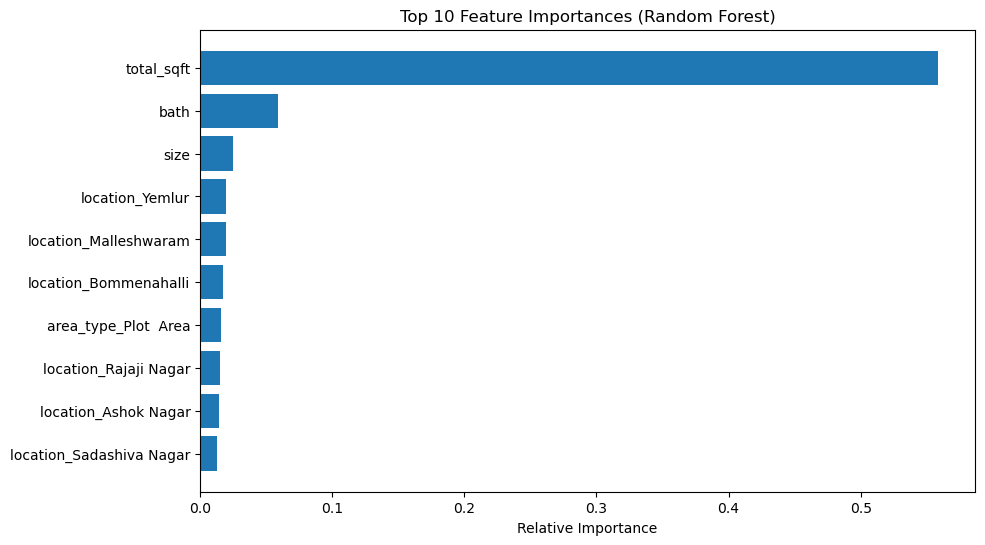

In [36]:
# Feature Importance from Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
feature_names = X.columns

# Sort feature importances
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [37]:
# Import evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define evaluation function
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print("Model Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")

# Evaluate the hybrid model
evaluate_model(y_test, y_pred_hybrid)


Model Evaluation Metrics:
Mean Absolute Error (MAE): 32.52
Mean Squared Error (MSE): 12824.86
Root Mean Squared Error (RMSE): 113.25
R² Score: 0.58


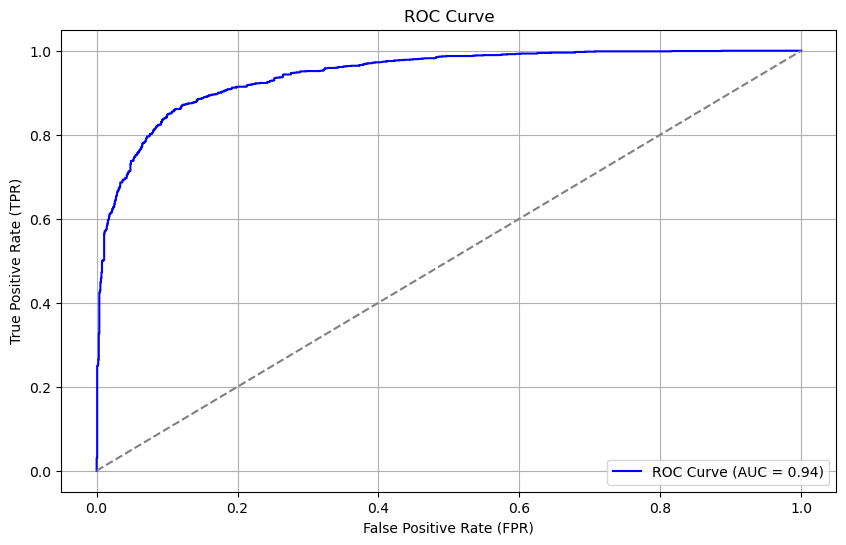

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score


# Convert regression target to binary classification (e.g., high price vs low price)
threshold = y.median()  # Use median price as the threshold
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred_hybrid > threshold).astype(int)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_hybrid)
roc_auc = roc_auc_score(y_test_binary, y_pred_hybrid)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


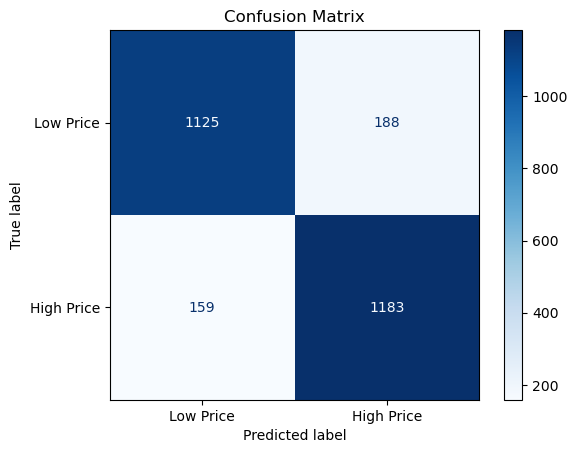

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert regression target to binary classification (e.g., high price vs low price)
threshold = y.median()  # Use median price as the threshold
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred_hybrid > threshold).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Price', 'High Price'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Convert regression target to binary classification (e.g., high price vs low price)
threshold = y.median()  # Use median price as the threshold
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred_hybrid > threshold).astype(int)

# Calculate Metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Accuracy: 0.87
Precision: 0.86
Recall: 0.88


In [41]:
# Evaluate the Hybrid Model

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2 Score': r2}

results = evaluate_model(y_test, y_pred_hybrid)
print("Hybrid Model Evaluation:")
print(results)

Hybrid Model Evaluation:
{'MAE': 32.52207430528187, 'MSE': 12824.863952292477, 'RMSE': 113.24691586216588, 'R2 Score': 0.5774396563356112}
